In [ ]:
#xyxy: [tensor(79., device='cuda:0'), tensor(170., device='cuda:0'), tensor(205., device='cuda:0'), tensor(319., device='cuda:0')]
#xyxy: [tensor(249., device='cuda:0'), tensor(70., device='cuda:0'), tensor(861., device='cuda:0'), tensor(515., device='cuda:0')]

In [ ]:
# !python detect.py --weights /content/yolov5/yolov5m.pt --img 416 --conf 0.45 --iou-thres=0.45 --source ../elephant2.png

### Pytorch install
### conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

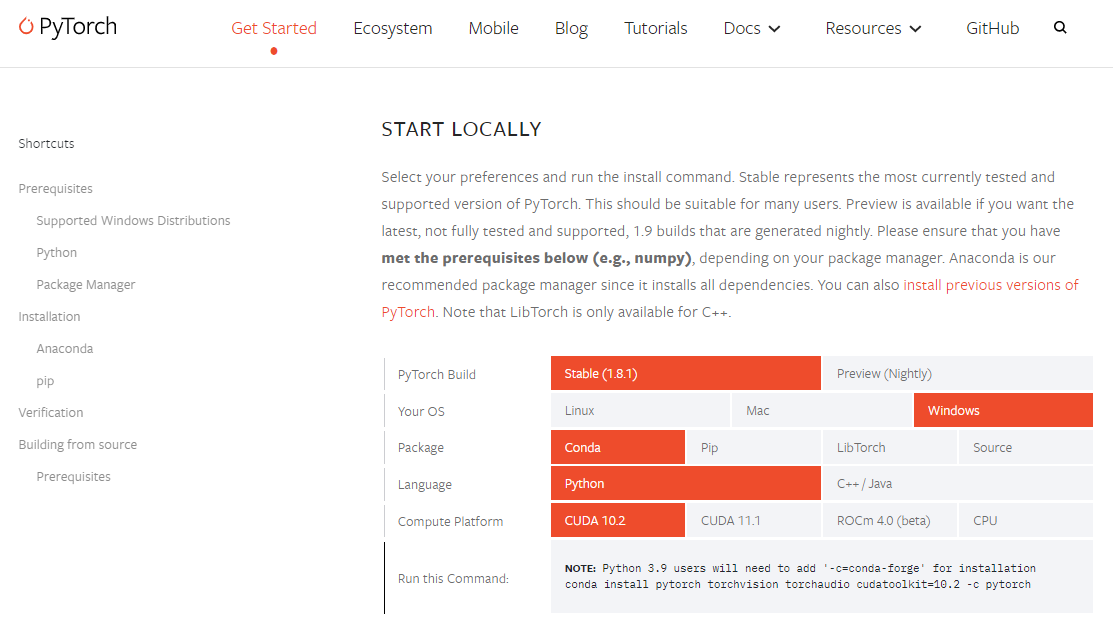

In [1]:
import sys
import numpy as np
import cv2

src = cv2.imread('elephant2.png')

if src is None:
    print('image load failed')
    sys.exit()

#cropped=src[200:500, 450:650]
#flipped = cv2.flip(src, -1)
    
cv2.imshow('Image', src)
#cv2.imshow('Flipped', flipped)
#cv2.imshow('Cropped Image', cropped)
cv2.waitKey(0) # 0 forever 
cv2.destroyAllWindows()


In [2]:
import cv2

# Read in an image
img = cv2.imread('elephant2.png')

# Cropping
cropped1 = img[170:319, 79:205] #
cv2.imshow('Cropped 1', cropped1)

cropped2 = img[70:515, 249:861] #
cv2.imshow('Cropped 2', cropped2)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import argparse
import time
from pathlib import Path
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

In [7]:
#from models.experimental import attempt_load

In [7]:
# Model .\model directory

### !pip install tqdm
### !pip install pandas
### !pip install PyYAML
### !pip install matplotlib
### !pip install seaborn

In [2]:
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [3]:
import glob
import logging
import math
import os
import random
import shutil
import time
from itertools import repeat
from multiprocessing.pool import ThreadPool
from pathlib import Path
from threading import Thread

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ExifTags
from torch.utils.data import Dataset
from tqdm import tqdm

from utils.general import check_requirements, xyxy2xywh, xywh2xyxy, xywhn2xyxy, xyn2xy, segment2box, segments2boxes, \
    resample_segments, clean_str
from utils.torch_utils import torch_distributed_zero_first

from models.common import Conv, DWConv
import torch.nn as nn
from utils.google_utils import attempt_download

###

class Ensemble(nn.ModuleList):
    # Ensemble of models
    def __init__(self):
        super(Ensemble, self).__init__()

    def forward(self, x, augment=False):
        y = []
        for module in self:
            y.append(module(x, augment)[0])
        # y = torch.stack(y).max(0)[0]  # max ensemble
        # y = torch.stack(y).mean(0)  # mean ensemble
        y = torch.cat(y, 1)  # nms ensemble
        return y, None  # inference, train output


def attempt_load(weights, map_location=None):
    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
    model = Ensemble()
    for w in weights if isinstance(weights, list) else [weights]:
        attempt_download(w)
        ckpt = torch.load(w, map_location=map_location)  # load
        model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval())  # FP32 model

    # Compatibility updates
    for m in model.modules():
        if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True  # pytorch 1.7.0 compatibility
        elif type(m) is Conv:
            m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility

    if len(model) == 1:
        return model[-1]  # return model
    else:
        print('Ensemble created with %s\n' % weights)
        for k in ['names', 'stride']:
            setattr(model, k, getattr(model[-1], k))
        return model  # return ensemble

In [4]:
def detect(save_img=False):
    source, weights, view_img, save_txt, imgsz = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment=opt.augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        print('xywh: {}'.format(xywh))
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)

            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--weights', nargs='+', type=str, default='yolov5s.pt', help='model.pt path(s)')
parser.add_argument('--source', type=str, default='.\\images', help='source')  # file/folder, 0 for webcam
parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
parser.add_argument('--conf-thres', type=float, default=0.25, help='object confidence threshold')
parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
parser.add_argument('--view-img', action='store_true', help='display results')
parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
parser.add_argument('--augment', action='store_true', help='augmented inference')
parser.add_argument('--update', action='store_true', help='update all models')
parser.add_argument('--project', default='runs/detect', help='save results to project/name')
parser.add_argument('--name', default='exp', help='save results to project/name')
parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
opt = parser.parse_args(args=[])

In [6]:
weights='.\\yolov5s.pt'
img=416
conf=0.5
source='elephant2.png'

In [25]:
### !python detect.py --weights .\yolov5s.pt --img 416 --conf 0.5 --source .\images\elephant2.png --nosave

In [7]:
if __name__ == '__main__':
    detect()

YOLOv5  2021-4-15 torch 1.8.1 CUDA:0 (GeForce MX250, 2048.0MB)



Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients


image 1/16 C:\Users\user\Documents\SDF\SDF-CV\images\Daisy1.jpg: 480x640 Done. (0.032s)
image 2/16 C:\Users\user\Documents\SDF\SDF-CV\images\antivirus.jpg: 480x640 3 bottles, 2 bowls, Done. (0.039s)
image 3/16 C:\Users\user\Documents\SDF\SDF-CV\images\banana1.jpg: 448x640 1 banana, Done. (0.032s)
image 4/16 C:\Users\user\Documents\SDF\SDF-CV\images\banana2.jpg: 416x640 3 bananas, Done. (0.031s)
image 5/16 C:\Users\user\Documents\SDF\SDF-CV\images\banana3.png: 480x640 Done. (0.031s)
image 6/16 C:\Users\user\Documents\SDF\SDF-CV\images\bicycle.png: 480x640 Done. (0.026s)
image 7/16 C:\Users\user\Documents\SDF\SDF-CV\images\elephant1.jpg: 448x640 1 elephant, Done. (0.030s)
image 8/16 C:\Users\user\Documents\SDF\SDF-CV\images\elephant2 (1).png: 384x640 2 elephants, Done. (0.030s)
image 9/16 C:\Users\user\Documents\SDF\SDF-CV\images\elephant2.png: 384x640 2 elephants, Done. (0.025s)
image 10/16 C:\Users\user\Documents\SDF\SDF-CV\images\giraffe.jpg: 480x640 6 persons, 1 car, 1 giraffe, 1 bow